In [1]:
import sys 
sys.path.append('..')
from utils import wasserstein2
from kernels import *
from distributions import *
from kernelGAN import *
import torch, matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML

device = torch.device('cpu')
%matplotlib inline
plt.rcParams.update({'font.size': 20})
%load_ext autoreload
%autoreload 2

## 1D Case

In [2]:
# distribution params
n_true, n_gen, d = 1, 1, 1
n_mixture, sigma = 0, 0
init_dists = [0.1, 1, 10]

# initializing discriminator kernel
width_params=[[0.1], [1], [10], [0.1, 1], [1, 10], [0.1, 1, 10]]

# training params
T, lr_d, lr_g = 20000, 1e-3, 1e-3
lams = [1e-1, 1e-2, 0]
log_interval=10

In [3]:
W_dist = np.zeros((len(init_dists), len(lams), len(width_params), T//log_interval))
for i, init_dist in enumerate(init_dists):
    for j, lam in enumerate(lams):
        for k, width_param in enumerate(width_params):
            # init kernel
            weights = torch.tensor([1/width for width in width_param])
            DK = Kernel('gaussian_ms', width_param=width_param, weights=weights)
            D = KernelDiscriminator(DK, d, lam, lr_d, device)
            # initializing points
            X_true = torch.tensor([[0]], dtype=torch.float32)
            X_gen_init = torch.tensor([[init_dist]], dtype=torch.float32)
            p_gen = torch.randn(n_gen).softmax(-1)
            p_true = torch.randn(n_true).softmax(-1)
            G = PointGenerator(X_gen_init, p_gen)
            # find generated trajectories
            model = KernelGAN(G, D, device)
            model.train(X_true, p_true, lr_d, lr_g, T, lam)
            # calculate w2 distances
            curr_w2 = wasserstein2(model.G.X_gen.detach().cpu(), X_true.detach().cpu(), log_interval)
            W_dist[i, j, k, :] = curr_w2

100%|██████████| 2000/2000 [00:01<00:00, 1471.54it/s]


In [4]:
def format_width(width_param):
    if len(width_param)==1:
        return width_param[0]
    else:
        return width_param

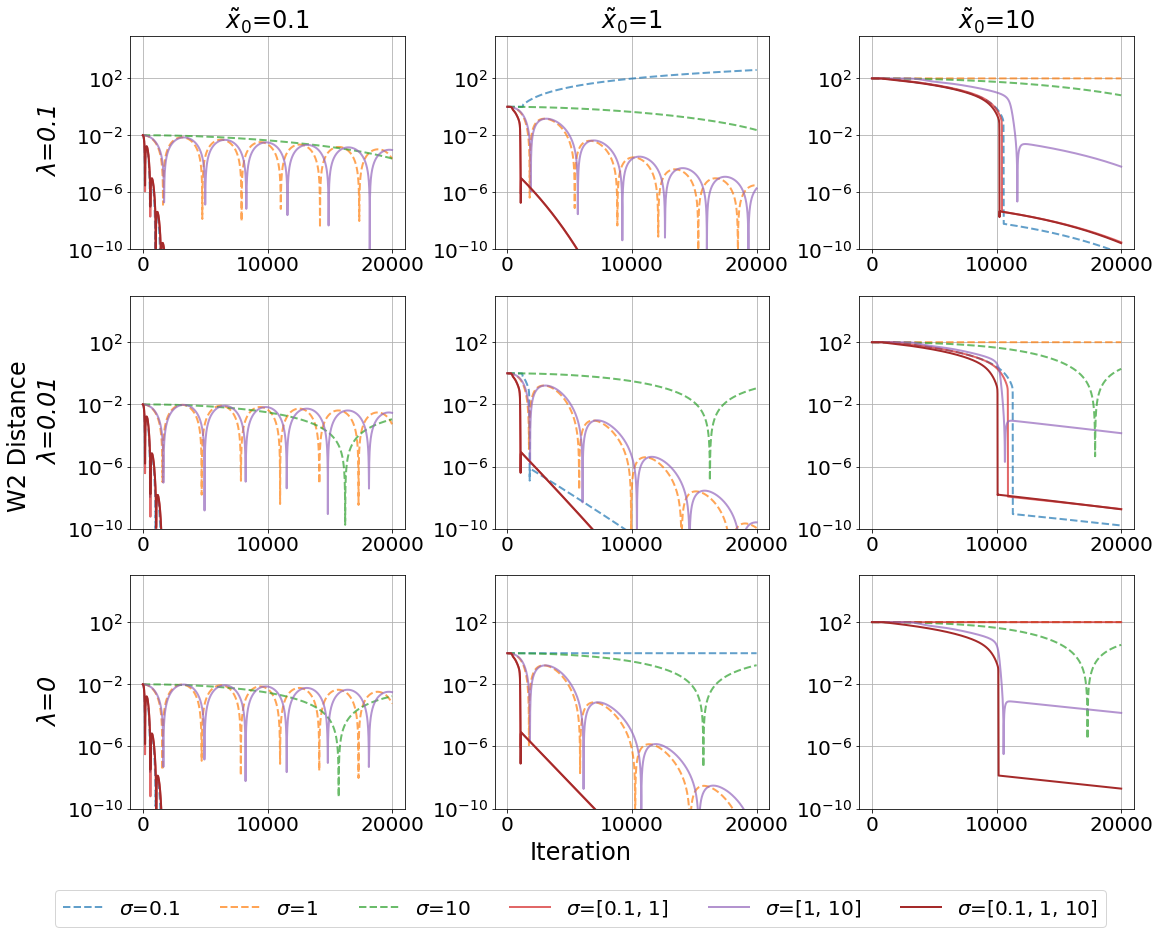

In [21]:
fig = plt.figure(figsize=(16,12), constrained_layout=True)
# fig.suptitle('Figure title')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.supylabel(f'$\lambda$={lams[row]}', style='italic')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        for k, width_param in enumerate(width_params):
            if len(width_param)==3:
                ax.semilogy(list(range(0,T,log_interval)), W_dist[col, row, k,:], 
                            label=f'$\sigma$={format_width(width_param)}', linewidth=2, color='brown', alpha=1)
            elif len(width_param)>1:
                ax.semilogy(list(range(0,T,log_interval)), W_dist[col, row, k,:], c=f'C{k}',
                            label=f'$\sigma$={format_width(width_param)}', linewidth=2, alpha=0.7)
            else:
            # if len(width_param)==1:
                ax.semilogy(list(range(0,T,log_interval)), W_dist[col, row, k,:], c=f'C{k}', 
                            label=f'$\sigma$={format_width(width_param)}', linewidth=2, alpha=0.7, ls='dashed')
            ax.set_ylim((10**-10,10**5))
        ax.grid()
        if row==0:
            ax.set_title(f'$\\tilde{{x}}_0$={init_dists[col]}')
        ax.plot()
        handles, labels = ax.get_legend_handles_labels()
fig.supylabel('W2 Distance')
fig.supxlabel('Iteration')
# fig.subplots_adjust(bottom=0.1)
fig.legend(labels=labels, loc="lower center", bbox_to_anchor=(0.5, -0.08), ncol=6)
# plt.savefig(f"../data/ngen_and_dimensions.png", format='png', bbox_inches='tight')

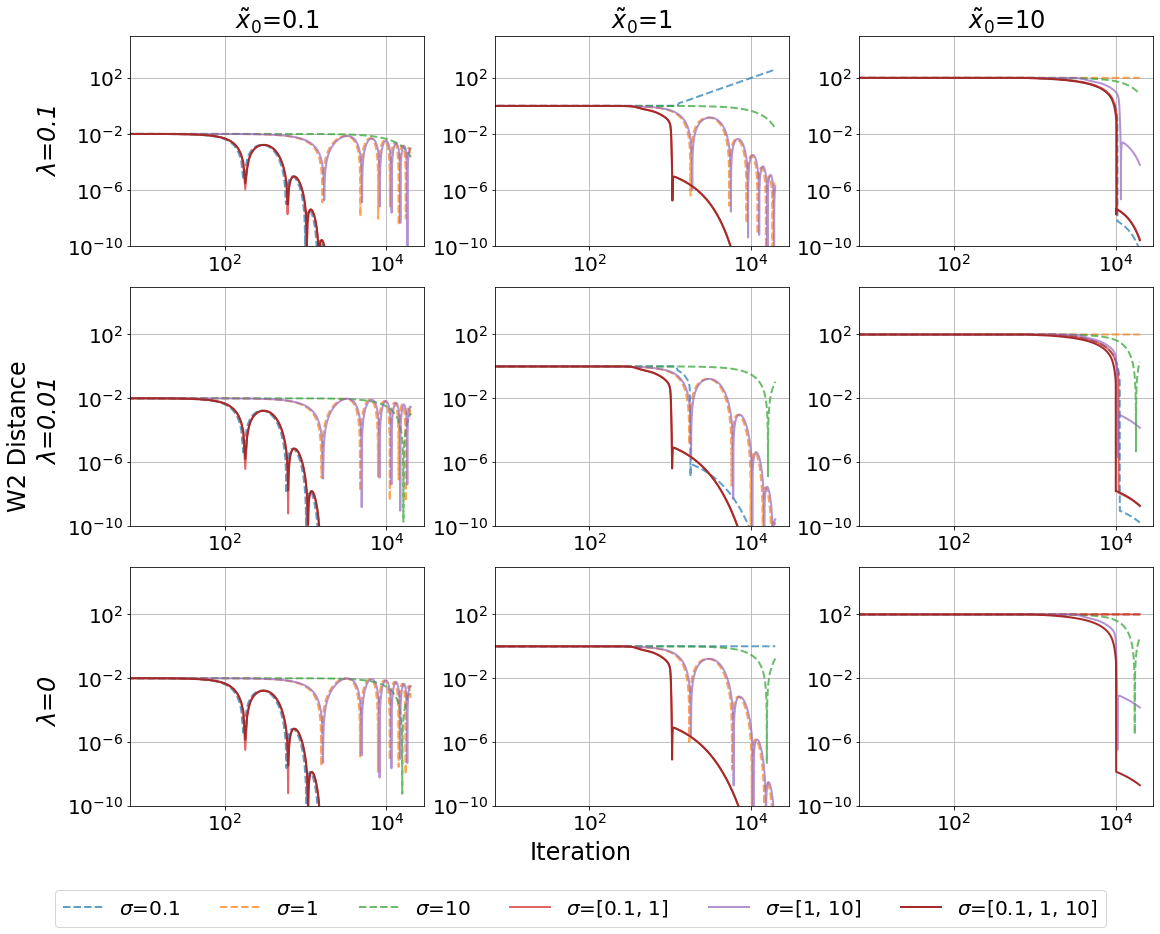

In [22]:
fig = plt.figure(figsize=(16,12), constrained_layout=True)
# fig.suptitle('Figure title')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.supylabel(f'$\lambda$={lams[row]}', style='italic')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        for k, width_param in enumerate(width_params):
            if len(width_param)==3:
                ax.loglog(list(range(0,T,log_interval)), W_dist[col, row, k,:], 
                            label=f'$\sigma$={format_width(width_param)}', linewidth=2, color='brown', alpha=1)
            elif len(width_param)>1:
                ax.loglog(list(range(0,T,log_interval)), W_dist[col, row, k,:], c=f'C{k}',
                            label=f'$\sigma$={format_width(width_param)}', linewidth=2, alpha=0.7)
            else:
            # if len(width_param)==1:
                ax.loglog(list(range(0,T,log_interval)), W_dist[col, row, k,:], c=f'C{k}', 
                            label=f'$\sigma$={format_width(width_param)}', linewidth=2, alpha=0.7, ls='dashed')
            ax.set_ylim((10**-10,10**5))
        ax.grid()
        if row==0:
            ax.set_title(f'$\\tilde{{x}}_0$={init_dists[col]}')
        ax.plot()
        handles, labels = ax.get_legend_handles_labels()
fig.supylabel('W2 Distance')
fig.supxlabel('Iteration')
# fig.subplots_adjust(bottom=0.1)
fig.legend(labels=labels, loc="lower center", bbox_to_anchor=(0.5, -0.08), ncol=6)
# plt.savefig(f"../data/ngen_and_dimensions.png", format='png', bbox_inches='tight')

In [6]:
# animate the generated point trajectories
figure, axes = plt.subplots(figsize=(8,5)) 
camera = Camera(figure)
lim = 10

# plot initial distribution
plt.scatter(X_true, np.zeros_like(X_true),c='r', label='true', marker='*')
# plt.scatter(X_true[:,0],X_true[:,1],c='w', edgecolor='b',alpha=.5)
plt.xlim([-lim,lim]); plt.ylim([-lim,lim])
scat=plt.scatter(model.G.X_gen[0,:], np.zeros_like(model.G.X_gen[0,:]), c='g', label='gen')
plt.legend(loc='upper right')

# updating generated points
plt_interval = 50
for i, sample_idx in enumerate(range(0,T, plt_interval)):
    plt.scatter(X_true, np.zeros_like(X_true),c='r', label='true', marker='*')
    plt.scatter(model.G.X_gen[sample_idx,:], np.zeros_like(model.G.X_gen[sample_idx,:]), c='g', label='gen')
    camera.snap()

plt.close()
anim = camera.animate()
HTML(anim.to_html5_video())
# anim.save('./test.gif',
#                dpi=300,
#                savefig_kwargs={
#                    'pad_inches': 'tight'
#                }
#               )

## 2D Case

In [18]:
# distribution params
n_true, n_gen, d = 1, 1, 2
n_mixture, sigma = 0, 0
init_dists = [0.1, 1, 10]

# initializing discriminator kernel
width_params=[[0.1], [1], [10], [0.1, 1], [1, 10], [0.1, 1, 10]]

# training params
T, lr_d, lr_g = 20000, 1e-3, 1e-3
lams = [1e-1, 1e-2, 0]
log_interval=10

In [19]:
W_dist = np.zeros((len(init_dists), len(lams), len(width_params), T//log_interval))
for i, init_dist in enumerate(init_dists):
    for j, lam in enumerate(lams):
        for k, width_param in enumerate(width_params):
            # init kernel
            weights = torch.tensor([1/width for width in width_param])
            DK = Kernel('gaussian_ms', width_param=width_param, weights=weights)
            D = KernelDiscriminator(DK, d, lam, lr_d, device)
            # initializing points
            X_true = torch.tensor([[0, 0]], dtype=torch.float32)
            X_gen_init = torch.tensor([[init_dist,0]], dtype=torch.float32)
            p_gen = torch.randn(n_gen).softmax(-1)
            p_true = torch.randn(n_true).softmax(-1)
            G = PointGenerator(X_gen_init, p_gen)
            # find generated trajectories
            model = KernelGAN(G, D, device)
            model.train(X_true, p_true, lr_d, lr_g, T, lam)
            # calculate w2 distances
            curr_w2 = wasserstein2(model.G.X_gen.detach().cpu(), X_true.detach().cpu(), log_interval)
            W_dist[i, j, k, :] = curr_w2

100%|██████████| 2000/2000 [00:01<00:00, 1434.23it/s]


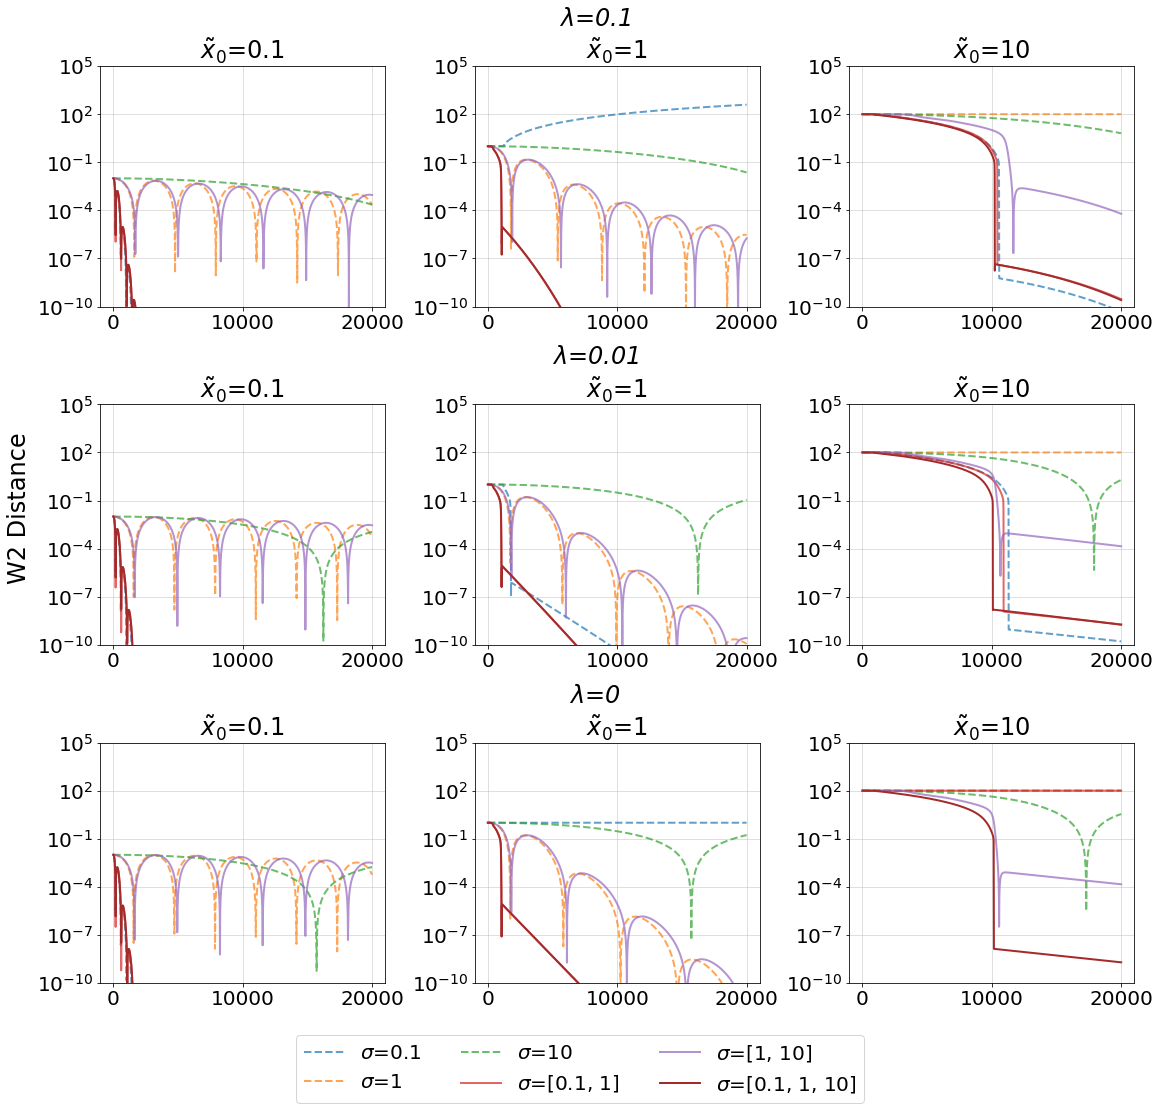

In [20]:
fig = plt.figure(figsize=(16,14), constrained_layout=True)
# fig.suptitle('Figure title')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(f'$\lambda$={lams[row]}', style='italic')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        for k, width_param in enumerate(width_params):
            if len(width_param)==3:
                ax.semilogy(list(range(0,T,log_interval)), W_dist[col, row, k,:], 
                            label=f'$\sigma$={format_width(width_param)}', linewidth=2, color='brown', alpha=1)
            elif len(width_param)>1:
                ax.semilogy(list(range(0,T,log_interval)), W_dist[col, row, k,:], c=f'C{k}',
                            label=f'$\sigma$={format_width(width_param)}', linewidth=2, alpha=0.7)
            else:
                ax.semilogy(list(range(0,T,log_interval)), W_dist[col, row, k,:], c=f'C{k}', 
                            label=f'$\sigma$={format_width(width_param)}', linewidth=2, alpha=0.7, ls='dashed')
            ax.set_ylim((10**-10,10**5))
        ax.grid(alpha=0.5)
        ax.set_title(f'$\\tilde{{x}}_0$={init_dists[col]}')
        ax.plot()
        handles, labels = ax.get_legend_handles_labels()
fig.supylabel('W2 Distance')
# fig.subplots_adjust(bottom=0.1)
fig.legend(labels=labels, loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=3)
# plt.savefig(f"../data/ngen_and_dimensions.png", format='png', bbox_inches='tight')

## Animation

In [7]:
# animate the generated point trajectories
width=width_param[0]
lim = 8
figure, axes = plt.subplots(figsize=(8,5)) 
camera = Camera(figure)

# plot initial distribution
cc1 = plt.Circle(X_true[0], width, alpha=0.1); cc2 = plt.Circle(X_true[1], width , alpha=0.1) 
# cc3 = plt.Circle(X_true[2], width_param , alpha=0.1); cc4 = plt.Circle(X_true[3], width_param , alpha=0.1) 
axes.set_aspect(1); axes.add_artist(cc1); axes.add_artist(cc2) 
plt.scatter(X_true[:,0],X_true[:,1],c='r', label='true', marker='*')
# plt.scatter(X_true[:,0],X_true[:,1],c='w', edgecolor='b',alpha=.5)
plt.xlim([-lim,lim]); plt.ylim([-lim,lim])
scat=plt.scatter(model.G.X_gen[0,:,0],model.G.X_gen[0,:,1],c='g', label='gen')
plt.legend(loc='upper right')

# updating generated points
plt_interval = 50
for i, sample_idx in enumerate(range(0,T, plt_interval)):
    # print(sample_idx)
    # print(X_gen[sample_idx,:,0])
    cc1 = plt.Circle(X_true[0], width , alpha=0.1); cc2 = plt.Circle(X_true[1], width , alpha=0.1) 
    # cc3 = plt.Circle(X_true[2], width_param , alpha=0.1); cc4 = plt.Circle(X_true[3], width_param , alpha=0.1) 
    axes.set_aspect(1); axes.add_artist(cc1); axes.add_artist(cc2)
    x0, x1, u, v = model.get_grad_field(sample_idx-1, xlim=[-lim,lim], ylim=[-lim,lim], nplt=20)
    plt.quiver(x0,x1,u,v)
    plt.scatter(model.G.X_gen[sample_idx,:,0], model.G.X_gen[sample_idx,:,1], c='g', label='gen')
    plt.scatter(X_true[:,0],X_true[:,1],c='r', label='true', marker='*')
    camera.snap()

plt.close()
anim = camera.animate()
HTML(anim.to_html5_video())
# anim.save('../data/nngp_weird_field.gif',
#                dpi=300,
#                savefig_kwargs={
#                    'frameon': False,
#                    'pad_inches': 'tight'
#                }
#               )